## Paolo's code refactoring from Syed's original
https://github.com/PaoloMissier/MLTC-Patient_modelling/tree/master/notebooks/SYED

In [1]:
import pandas as pd
import numpy as np
import math
from os.path import exists

import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
%matplotlib inline



from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Progress bar
from tqdm.notebook import tqdm

# Word Counter
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pprint
pp = pprint.PrettyPrinter(indent=4)
import scipy.stats as ss
import itertools

## local imports
from  CommonFunctions import *
from Constants import *

# Pre-Processing

In [2]:
FORCE_RECOMPUTE = False

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Pipeline execution

## from the binary matrix, create the bag of words to feed LDA

In [3]:
## use cached pickle file is available 

if exists(BOWs) and not FORCE_RECOMPUTE:
    with open(BOWs, 'rb') as f:
      bows =  pickle.load(f)
    print('loaded BOW list [{0}] from cache'.format(BOWs))
else:
    ltc_patients = pd.read_csv(LTC_BINARY, sep = '\t')
    bows = create_bows(ltc_patients)
    
print("working with {0} bows (= patients)".format(len(bows)))

loaded BOW list [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/cluster-assignments/MLTC-Patient_modelling/data/BOWs.pkl] from cache
working with 143168 bows (= patients)


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### summary stats about our bags of words

In [4]:
all_len = 0

for text in bows:
    all_len += len(text)
    
avg_len = all_len/len(bows)

print("All words: {n}".format(n=all_len))
print("Average LTCs per patient: {n}".format(n=avg_len))
print("Maximum amount of LTCs: {n}".format(n= max(len(x) for x in bows)))
print("Minimum amount of LTCs: {n}".format(n= min(len(x) for x in bows)))
print("Patients in corpus: {l}".format(l=len(bows)))
print("Example of patient record:\n {n}".format(n=bows[1]))

All words: 1104514
Average LTCs per patient: 7.714810572194904
Maximum amount of LTCs: 37
Minimum amount of LTCs: 4
Patients in corpus: 143168
Example of patient record:
 ['female_genital_prolapse', 'fracture_hip', 'obesity', 'spondylosis', 'type_2_diabetes', 'unspecified_rare_diabetes', 'urine_incont']


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/npm65/opt/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


### distribution of disease terms in the corpus

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/npm65/opt/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


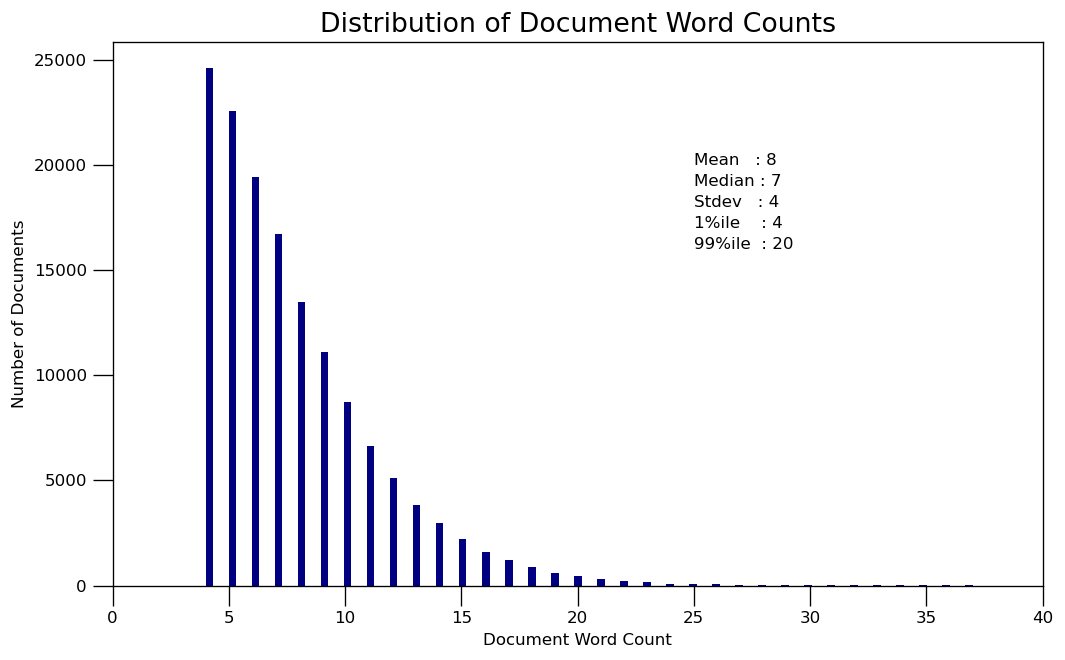

In [5]:
doc_lens = [len(d) for d in bows]

# Plot
plt.figure(figsize=(10,6), dpi=120)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(25, 20000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(25,  19000, "Median : " + str(round(np.median(doc_lens))))
plt.text(25,  18000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(25,  17000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(25,  16000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 40), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,40,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=16))
plt.show()

## Topics generation

### will iterate over multiple numbers of topics

## code needs to be generalised

In [6]:
topics_count = 4
# Note: num_topics attempted: 20, 15, 10, 5, 6, ,7 , 8, 4

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### load / generate topic model

In [7]:
if exists(LDA_MODEL) and not FORCE_RECOMPUTE:
    with open(LDA_MODEL, 'rb') as f:
      lda_model = pickle.load(f)
      print('loaded model [{0}] from cache'.format(LDA_MODEL))
else:
    lda_model = bagOfWords2Topics(bows, topics_count)
    


loaded model [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/cluster-assignments/MLTC-Patient_modelling/data/lda_model.pkl] from cache


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### compute dataframe with rwidf association to each topic

this is the main dataframe we will use to track patient associations given their BOWs

In [8]:
## use cached pickle file is available 

if exists(TERMS_REL_WEIGHTS_IDF) and not FORCE_RECOMPUTE:
    with open(TERMS_REL_WEIGHTS_IDF, 'rb') as f:
      terms_topics_df = pd.read_csv(f)
      print('loaded terms_topics_df [{0}] from cache'.format(TERMS_REL_WEIGHTS_IDF))
else:
    terms_topics_df = compute_terms_topics_associations(lda_model)

loaded terms_topics_df [/Users/npm65/OneDrive - Newcastle University/NIHR-AI-MLTC-M/CODE/cluster-assignments/MLTC-Patient_modelling/data/terms_rel_weights_idf.csv] from cache


/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
terms_topics_df

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,MLTC,topic 1,topic 2,topic 3,topic 4,occurrences,idf,rwidf1,rwidf2,rwidf3,rwidf4
0,0,ADHD,0.000002,0.000004,0.000008,0.000984,71,3.298513,0.150478,0.315440,0.544459,69.989624
1,1,BAD,0.000002,0.000004,0.000009,0.013487,1112,2.109351,0.183892,0.350273,0.743001,1110.722834
2,2,BPH,0.000002,0.035084,0.000007,0.000019,9897,1.160299,0.688379,9888.975770,1.916242,5.419609
3,3,CCD,0.000003,0.004811,0.000008,0.000018,1424,2.002031,0.796093,1415.594862,2.277394,5.331652
4,4,CHD,0.000003,0.051222,0.000008,0.024346,16044,0.950506,0.597504,10873.488765,1.715195,5168.198537
...,...,...,...,...,...,...,...,...,...,...,...,...
198,198,varices_portal_hypert,0.000002,0.000004,0.000006,0.004023,347,2.614267,0.192849,0.381505,0.545012,345.880634
199,199,venous_lymphatic,0.024791,0.011285,0.002639,0.000036,17787,0.905719,11378.957568,5180.082133,1211.446283,16.514016
200,200,venous_thromb,0.000004,0.019338,0.000010,0.000021,5355,1.427005,1.137958,5345.233847,2.813845,5.814350
201,201,vitb12_deficiency,0.005834,0.000078,0.000014,0.020434,5032,1.454019,1113.681567,14.857260,2.704069,3900.757104


### generate word clouds for the topics

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


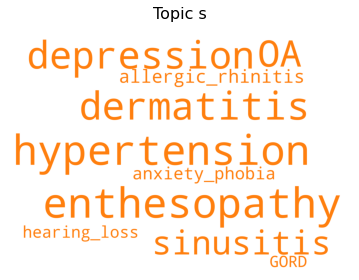

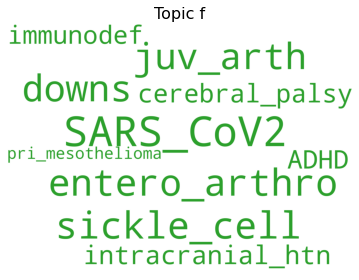

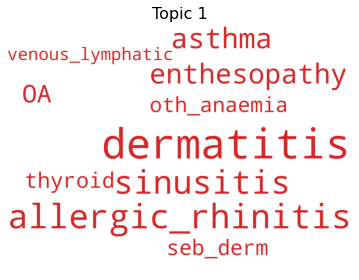

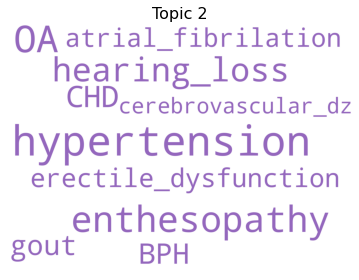

In [10]:
createWordClouds(terms_topics_df)

## compute the tensor that holds the patient-topic association __for each term in the patient's history__


In [11]:
## computing for all bows, the result is in the trajectories nesteed dict (see method def computeTrajectoryAssociations above)

len(bows)

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


143168

In [12]:
FORCE_RECOMPUTE = True

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:


# bream down a bow into its stages, for instance:
#  bow = ['OA', 'skin_ulcer', 'dermatitis']
#  stages = [['OA'], ['OA', 'skin_ulcer'], ['OA', 'skin_ulcer', 'dermatitis']]
def getStages(bow):
        stages = []
        for i in range(len(bow)):
            stage = stages.append(bow[0:i+1])
        return stages


# look up each term in bowStage. add up all partial association strength for each topic, generating an array of size K = number of topic
def assoc(bowstage, rwidf, topics_count):
    assocVector = np.zeros(topics_count)
    for term in bowstage:
        row = rwidf.loc[terms_topics_df['MLTC'] == term]
#         print(row[['rwidf1', 'rwidf2', 'rwidf3', 'rwidf4']])
        assocVector[0] += row['rwidf1']
        assocVector[1] += row['rwidf2']
        assocVector[2] += row['rwidf3']
        assocVector[3] += row['rwidf4']
    return assocVector



##########################
### compute the tensor that holds the patient-topic association __for incremental bag of terms in the patient's history__
##########################

## main method to compute the 'tensor' as a nested dictionary:
# bows = list(bow)
# bow = list(bowStage)
# bowStage = list(term)
# term --> association vector of size K = number of topics
# so:
#    all_patients_traj = { id(bow): one_patient_trajectory}
#    one_patient_trajectory = { id(bowStage): assoc vector}
#  to use hashing we need to create an id for each bow (id=patient) and one id for each stage in that patient's history.
#  note that these are not the native patient IDs which are lost at this point
#
# return all_patients_traj
#

def computeTrajectoryAssociations(bows, rwidf, topics_count):

    bowID2bow = dict()  ## need to use bowIDs as hash keys so this dict maps bowID to the actual bow content
    bowId = 1 # makes hashing possible
    all_patients_traj = dict()  ## top level dict
    
    for bow in bows:    # for each bag of word (each patient)
#         print("processing bowId {0}: [{1}]".format(bowId, bow))
        
        bowID2bow[bowId] = bow
        traj = all_patients_traj[bowId] = dict()  ## individual trajectory is itself a dict()
        bowStageId = 1
        for bowStage in getStages(bow):  # compute association vector for each of its stages
#             print("processing bowStage [{0}]".format(bowStage))
            
            traj[bowStageId]  = assoc(bowStage, rwidf, topics_count)
#             print("vector for bowStageId [{0}]: {1}".format(bowStageId, traj[bowStageId]))
            bowStageId += 1
#         print("trajectory: {0}\n".format(traj))
        bowId += 1
        if bowId % 1000 == 0:
            print("{0} patients processed".format(bowId))
            
    ## save main trajectories data structure

    with open(ALL_TRAJECTORIES, 'wb') as f:
        pickle.dump(trajectories, f)

    with open(BOWID2BOW, 'wb') as f:
        pickle.dump(bowId2bow, f)

    return all_patients_traj, bowID2bow


def pprint(trajectory):
    for bowStageId in trajectory.keys():
        print("stage {0}: {1}".format(bowStageId, trajectory[bowStageId]))
        

/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# hist = ['OA', 'skin_ulcer', 'dermatitis', 'erectile_dysfunction', 'pri_skin']
# hist = ['OA', 'skin_ulcer', 'dermatitis']
# hist  = ['spondylosis', 'obesity', 'urine_incont', 'female_genital_prolapse', 'type_2_diabetes', 'unspecified_rare_diabetes', 'fracture_hip']
# hist = ['asthma', 'hypertension', 'hearing_loss', 'alcohol_depend']
# hist = ['venous_lymphatic', 'psoriasis', 'female_genital_prolapse', 'CHD', 'alcohol_depend', 'obesity', 'hearing_loss', 'urine_incont']
# hist = ['PTSD', 'COPD', 'neuro_bladder', 'female_genital_prolapse', 'OA'] 
# hist = ['dermatitis', 'hypertension', 'atrial_fibrilation', 'OA', 'tinnitus']

# bows = [['OA', 'skin_ulcer', 'dermatitis'],['asthma', 'hypertension', 'hearing_loss', 'alcohol_depend']]

if exists(ALL_TRAJECTORIES) and exists(BOWID2BOW) and not FORCE_RECOMPUTE:
    with open(ALL_TRAJECTORIES, 'rb') as f:
      trajectories =  pickle.load(f)
      print('loaded trajectories [{0}] from cache'.format(ALL_TRAJECTORIES))

    with open(BOWID2BOW, 'rb') as g:
      bowId2bow =  pickle.load(g)
      print('loaded bowId2bow [{0}] from cache'.format(BOWID2BOW))

else:
    print("starting computation of *all* trajectories for {0} bows (= patients)".format(len(bows)))
    trajectories, bowId2bow = computeTrajectoryAssociations(bows, terms_topics_df, topics_count)



/Users/npm65/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


starting computation of *all* trajectories for 143168 bows (= patients)
1000 patients processed
2000 patients processed
3000 patients processed
4000 patients processed
5000 patients processed
6000 patients processed
7000 patients processed
8000 patients processed
9000 patients processed
10000 patients processed
11000 patients processed
12000 patients processed
13000 patients processed
14000 patients processed
15000 patients processed
16000 patients processed
17000 patients processed
18000 patients processed
19000 patients processed
20000 patients processed
21000 patients processed
22000 patients processed


In [ ]:

    bowId2bow
